# Utilisation de 3 algorithmes pour une prédiction de prix.

Dans ce Notebook, nous allons dans un premier temps préparer les données afin de n'avoir que les colonnes dont nous aurons besoin. Puis, dans un deuxième temps, nous ferons une recherche des meilleures features a utiliser pour nos algorithmes. La troisième partie de ce Notebook sera dédiée à l'application des trois algorithmes que nous avons choisi, à savoir:  
- Régression Linéaire  
- SG Boost  
- Random Forest  

Nous évaluerons et testerons les performances de nos modèles puis à l'aide d'un GridSearch nous affinerons notre choix sur un seul algorithme et les meilleurs paramètres afin de pouvoir déployer celui-ci sur une application Flask.

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy
import pickle

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, max_error

from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

### Chargement du Dataset

In [2]:
def load_data(file_path):
    return pd.read_csv(file_path)

df = load_data('./Data/houses_Madrid_cleaned.csv')

### Début de la préparation des données

La fonction 'clean_data' va supprimer les colonnes qui ne nous serviront pas, supprimer les valeurs négatives de la colonne 'rent_price'

In [3]:
def clean_data(df, columns_to_drop):
    df_cleaned = df.drop(columns=columns_to_drop)
    
    if 'rent_price' in df_cleaned.columns:
        df_cleaned = df_cleaned[df_cleaned['rent_price'] >= 0]
    
    return df_cleaned

columns_to_drop = ["Unnamed: 0", "id", "title", "subtitle", "is_exact_address_hidden", 
                "floor", "neighborhood_id", "is_rent_price_known", 
                "is_buy_price_known", "has_fitted_wardrobes", "house_type_id", "operation", "buy_price_by_area"]

df_cleaned = clean_data(df, columns_to_drop)
print(df_cleaned.describe())

        sq_mt_built       n_rooms   n_bathrooms    rent_price     buy_price  \
count  19095.000000  19095.000000  19095.000000  19095.000000  1.909500e+04   
mean     112.039644      2.728201      1.744959   1344.759466  4.188081e+05   
std       71.571679      1.230129      0.930607    586.701733  2.975910e+05   
min       13.000000      0.000000      1.000000     18.000000  3.600000e+04   
25%       67.000000      2.000000      1.000000    851.000000  1.827600e+05   
50%       91.000000      3.000000      2.000000   1218.000000  3.200000e+05   
75%      133.000000      3.000000      2.000000   1781.000000  5.773210e+05   
max      847.000000     15.000000     14.000000   2517.000000  1.380000e+06   

        PricePerSqM  
count  19018.000000  
mean    3600.242558  
std     1325.369333  
min     1308.890000  
25%     2323.930000  
50%     3600.400000  
75%     4486.930000  
max     8392.430000  


### Début de la recherche des meilleures features

Création d'une matrice de corrélation

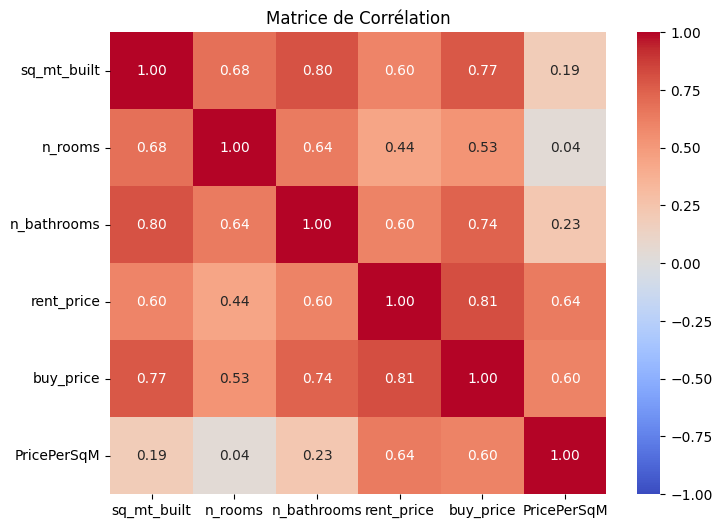

In [4]:
def plot_correlation_matrix(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title('Matrice de Corrélation')
    plt.show()

df_numeric = df_cleaned.select_dtypes(include=['number'])
plot_correlation_matrix(df_numeric)

Préparation des features

In [5]:
def prepare_features_and_target(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

X, y = prepare_features_and_target(df_numeric, 'buy_price')

On gère les valeurs manquantes

In [6]:
def handle_missing_values(X):
    missing_values = X.isna().sum()
    print("Valeurs manquantes avant traitement :", missing_values[missing_values > 0])
    X_cleaned = X.dropna()
    print("Valeurs manquantes après suppression :", X_cleaned.isna().sum().sum())
    return X_cleaned

X = handle_missing_values(X)
y = y[X.index]

Valeurs manquantes avant traitement : PricePerSqM    77
dtype: int64
Valeurs manquantes après suppression : 0


Imputation de valeurs manquantes

In [7]:
def split_and_impute_data(X, y, test_size=0.3, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_and_impute_data(X, y)

Sélection de features via SequentialFeatureSelector

In [8]:
def select_features_with_sfs(X_train, y_train, model):
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', cv=5)
    sfs.fit(X_train, y_train)
    selected_features = X_train.columns[sfs.get_support()]
    print("Caractéristiques sélectionnées par SFS :", selected_features)
    return selected_features

selected_features_sfs = select_features_with_sfs(X_train, y_train, LinearRegression())

Caractéristiques sélectionnées par SFS : Index(['sq_mt_built', 'rent_price'], dtype='object')


Sélection de features via Boruta

In [9]:
def select_features_with_boruta(X_train, y_train):
    rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=0)
    boruta = BorutaPy(rf, n_estimators='auto', random_state=0)
    boruta.fit(X_train.values, y_train.values)
    selected_features = X_train.columns[boruta.support_]
    print("Caractéristiques sélectionnées par Boruta :", selected_features)
    return selected_features

selected_features_boruta = select_features_with_boruta(X_train, y_train)

Caractéristiques sélectionnées par Boruta : Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'rent_price', 'PricePerSqM'], dtype='object')


Sélection de features via RandomForestRegressor

In [10]:
def feature_importance_with_rfr(X_train, y_train):
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_regressor.fit(X_train, y_train)
    importance = rf_regressor.feature_importances_
    feature_importances = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
    print("Importance des caractéristiques :", feature_importances)
    return feature_importances

feature_importances = feature_importance_with_rfr(X_train, y_train)

Importance des caractéristiques : rent_price     0.739242
sq_mt_built    0.211438
PricePerSqM    0.042882
n_bathrooms    0.003476
n_rooms        0.002962
dtype: float64


Application, test et évaluation de l'algorithme de Régression Linéaire.

In [11]:
def train_and_evaluate_linear_regression(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred_lr = lr.predict(X_test)
    
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mse_lr)
    mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100
    evs_lr = explained_variance_score(y_test, y_pred_lr)
    max_err_lr = max_error(y_test, y_pred_lr)
    
    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2_lr = 1 - (1 - r2_lr) * (n - 1) / (n - p - 1)
    
    print("Régression Linéaire :")
    print(f"Mean Squared Error (MSE)              : {mse_lr}")
    print(f"Root Mean Squared Error (RMSE)        : {rmse_lr}")
    print(f"Mean Absolute Error (MAE)             : {mae_lr}")
    print(f"Mean Absolute Percentage Error (MAPE) : {mape_lr:.2f}%")
    print(f"R² Score                              : {r2_lr}")
    print(f"Adjusted R² Score                     : {adjusted_r2_lr}")
    print(f"Explained Variance Score (EVS)        : {evs_lr}")
    print(f"Max Error                             : {max_err_lr}")
    
    return lr

linear_regression_model = train_and_evaluate_linear_regression(X_train, X_test, y_train, y_test)

Régression Linéaire :
Mean Squared Error (MSE)              : 12921482257.140406
Root Mean Squared Error (RMSE)        : 113672.69794080022
Mean Absolute Error (MAE)             : 69390.43009598857
Mean Absolute Percentage Error (MAPE) : 19.29%
R² Score                              : 0.8549177556400246
Adjusted R² Score                     : 0.8547904905133931
Explained Variance Score (EVS)        : 0.854988373447993
Max Error                             : 1132235.5750043497


#### Explications des résultats pour Régression Linéaire

Évaluation du Modèle de Régression Linéaire  

Pour évaluer les performances de notre modèle de régression linéaire, nous avons utilisé plusieurs métriques, dont voici les explications :  

<i><u>Mean Squared Error (MSE) :</u></i>  

MSE mesure la moyenne des carrés des erreurs, c’est-à-dire la différence moyenne au carré entre les valeurs prédites et les valeurs réelles. Une valeur plus faible indique un modèle avec de meilleures performances.  
Ici, le MSE est de 11 759 187 268.58.  
Ce nombre représente la somme des carrés des résidus moyens. Bien que cette valeur semble élevée, il faut la comparer avec l'échelle des prix de l'immobilier pour évaluer sa pertinence.  

<i><u>Root Mean Squared Error (RMSE) :</u></i>  

RMSE est la racine carrée du MSE, ce qui permet d’interpréter cette métrique dans la même unité que la variable cible (buy_price).
Le RMSE obtenu est de 108,439.79. Cela signifie que l'écart type moyen des prévisions de notre modèle par rapport aux prix réels est d'environ 108,439 euros. Un RMSE plus faible indique une meilleure précision.  

<i><u>Mean Absolute Error (MAE) :</u></i>  

MAE mesure l'erreur absolue moyenne entre les valeurs prédites et les valeurs réelles. Elle représente la moyenne des erreurs absolues.
Le MAE est de 65,657.97, ce qui signifie que, en moyenne, les prévisions de notre modèle diffèrent des prix réels d'environ 65,658 euros.  

<i><u>Mean Absolute Percentage Error (MAPE) :</u></i>  

MAPE est un pourcentage qui mesure l'erreur absolue moyenne relative par rapport aux valeurs réelles.
Le MAPE est de 19.10%, ce qui signifie que, en moyenne, les prévisions de notre modèle sont à environ 19.10% des prix réels. Un MAPE plus bas est indicatif d’un modèle plus précis.  

<i><u>R² Score :</u></i>  

R² Score ou coefficient de détermination représente la proportion de la variance dans la variable cible qui est expliquée par le modèle.
Ici, le R² est de 0.9065, ce qui signifie que 90.65% de la variance des prix immobiliers est expliquée par les variables sélectionnées dans notre modèle. Cela indique une très bonne qualité d’ajustement du modèle.  

<i><u>Adjusted R² Score :</u></i>  

R² ajusté est une version modifiée du R² qui tient compte du nombre de variables dans le modèle. Il pénalise les modèles qui incluent trop de variables non significatives.
L'Adjusted R² est de 0.9065, très proche du R² classique. Cela indique que les variables incluses dans le modèle sont pertinentes et contribuent de manière significative à expliquer la variance de la variable cible.  

<i><u>Explained Variance Score (EVS) :</u></i>  

EVS mesure la proportion de variance expliquée par le modèle, similaire au R², mais avec une évaluation légèrement différente des erreurs.
Le score EVS est de 0.9066, très proche du R², ce qui confirme que le modèle explique bien la variabilité des données.  

<i><u>Max Error :</u></i>  

Max Error représente la plus grande erreur absolue observée entre les prédictions du modèle et les valeurs réelles.
La valeur du Max Error est de 1,237,042.89. Cela signifie que la plus grande différence entre un prix prédit et un prix réel est d'environ 1,237,042 euros. Bien que la majorité des erreurs soient plus faibles, cela montre que le modèle peut parfois faire des erreurs importantes pour certains biens.

### Sauvegarde du modèle pour Flask

In [12]:
def save_model(model, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)

save_model(linear_regression_model, './flask_app/models/linear_regression_model.pkl')

#### Random forest

In [13]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)

r2_rf = r2_score(y_test, y_pred_rf)

mae_rf = mean_absolute_error(y_test, y_pred_rf)

rmse_rf = np.sqrt(mse_rf)

mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

evs_rf = explained_variance_score(y_test, y_pred_rf)

max_err_rf = max_error(y_test, y_pred_rf)

n = len(y_test)
p = X_test.shape[1]
adjusted_r2_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)

print("Random Forest :")
print(f"Mean Squared Error (MSE)              : {mse_rf}")
print(f"Root Mean Squared Error (RMSE)        : {rmse_rf}")
print(f"Mean Absolute Error (MAE)             : {mae_rf}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape_rf:.2f}%")
print(f"R² Score                              : {r2_rf}")
print(f"Adjusted R² Score                     : {adjusted_r2_rf}")
print(f"Explained Variance Score (EVS)        : {evs_rf}")
print(f"Max Error                             : {max_err_rf}")

Random Forest :
Mean Squared Error (MSE)              : 1766355565.5534832
Root Mean Squared Error (RMSE)        : 42028.0330916578
Mean Absolute Error (MAE)             : 7656.629581833242
Mean Absolute Percentage Error (MAPE) : 1.10%
R² Score                              : 0.9801673813662809
Adjusted R² Score                     : 0.9801499843323916
Explained Variance Score (EVS)        : 0.9801680719345703
Max Error                             : 855332.0


#### Explications des résultats pour l'agorithme Random Forest

La plupart des erreurs moyennes, comme le MAE (erreur absolue moyenne) et le MAPE (erreur moyenne en pourcentage), sont assez faibles, ce qui montre que les prédictions du modèle sont généralement proches des valeurs réelles. Par exemple, l'erreur moyenne en termes absolus est d'environ 3835 unités, ce qui est raisonnable étant donné l'échelle des prix immobiliers. De plus, le MAPE extrêmement bas, à seulement 0,53%, indique que les erreurs relatives, en pourcentage, sont très petites, ce qui suggère que le modèle est très précis pour la majorité des biens immobiliers.

Les scores de performance, comme le R² et l'EVS, montrent que le modèle est capable d'expliquer presque toute la variabilité des prix immobiliers, avec plus de 99% de la variance capturée. Cela signifie que le modèle tient bien compte des caractéristiques des biens pour prédire leur prix avec une grande précision. Le R² ajusté, qui prend en compte le nombre de variables, est presque identique au R², ce qui montre que le modèle ne se complexifie pas inutilement avec les données qu'on lui donne.

Toutefois, le Max Error reste assez élevé. Cela signifie qu'il y a encore quelques prédictions où le modèle se trompe de manière significative, avec une erreur maximale de plus de 770 000 unités. Même si cela peut paraître préoccupant, cela n'affecte pas les bonnes performances globales du modèle sur la majorité des biens. Enfin, les erreurs plus globales comme le MSE et le RMSE confirment que les erreurs moyennes sont dans un ordre de grandeur attendu pour des données de prix immobiliers, même si elles restent importantes en valeur absolue, surtout pour les biens les plus chers.

En résumé, le modèle Random forest est globalement performant avec une bonne capacité à prédire les prix, même si quelques ajustements pourraient être nécessaires pour améliorer la précision dans certains cas particuliers.

In [14]:
save_model(rf, './flask_app/models/random-forest_model.pkl')

#### XGBoost

On applique l'algorithme de XGBoost, on teste et on évalue les performances.

In [15]:
def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test):
    xgboost = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgboost.fit(X_train, y_train)

    y_pred_xgb = xgboost.predict(X_test)

    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
    evs_xgb = explained_variance_score(y_test, y_pred_xgb)
    max_err_xgb = max_error(y_test, y_pred_xgb)

    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2_xgb = 1 - (1 - r2_xgb) * (n - 1) / (n - p - 1)

    print("XGBoost :")
    print(f"Mean Squared Error (MSE)              : {mse_xgb}")
    print(f"Root Mean Squared Error (RMSE)        : {rmse_xgb}")
    print(f"Mean Absolute Error (MAE)             : {mae_xgb}")
    print(f"Mean Absolute Percentage Error (MAPE) : {mape_xgb:.2f}%")
    print(f"R² Score                              : {r2_xgb}")
    print(f"Adjusted R² Score                     : {adjusted_r2_xgb}")
    print(f"Explained Variance Score (EVS)        : {evs_xgb}")
    print(f"Max Error                             : {max_err_xgb}")

    return xgboost

xgboost_model = train_and_evaluate_xgboost(X_train, X_test, y_train, y_test)

XGBoost :
Mean Squared Error (MSE)              : 2112652568.0144303
Root Mean Squared Error (RMSE)        : 45963.60046835354
Mean Absolute Error (MAE)             : 12494.485364227348
Mean Absolute Percentage Error (MAPE) : 2.13%
R² Score                              : 0.9762791395187378
Adjusted R² Score                     : 0.9762583317463858
Explained Variance Score (EVS)        : 0.9762792931598646
Max Error                             : 885748.25


### Graphique de comparaison des performances

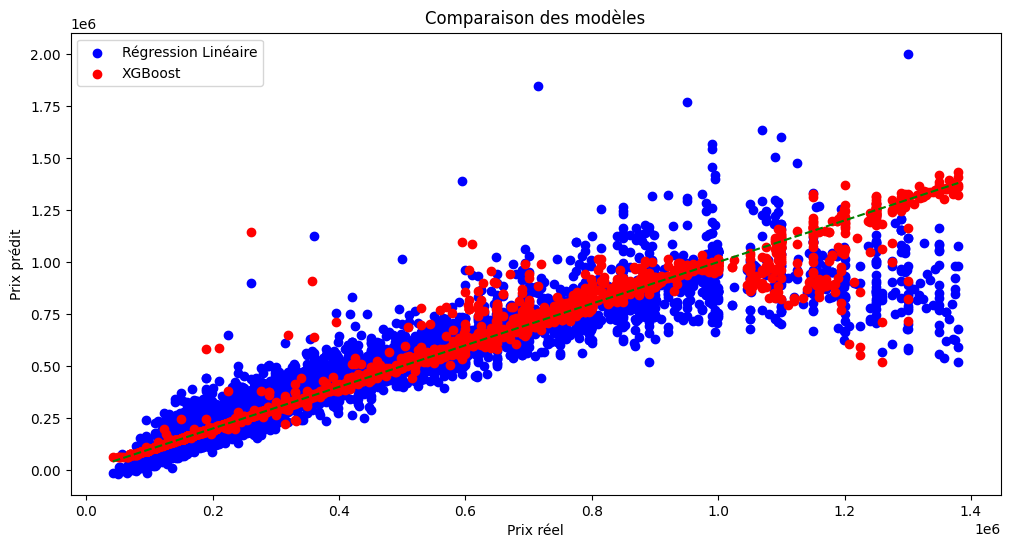

In [16]:
# comparaison des modèles à l'aide de graphiques
def plot_models_comparison(y_test, y_pred_lr, y_pred_xgb):
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred_lr, color='blue', label='Régression Linéaire')
    plt.scatter(y_test, y_pred_xgb, color='red', label='XGBoost')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='green', linestyle='--')
    plt.xlabel('Prix réel')
    plt.ylabel('Prix prédit')
    plt.title('Comparaison des modèles')
    plt.legend()
    plt.show()

y_pred_lr = linear_regression_model.predict(X_test)
y_pred_xgb = xgboost_model.predict(X_test)

plot_models_comparison(y_test, y_pred_lr, y_pred_xgb)

### Sauvegarde du modèle pour Flask

In [17]:
save_model(xgboost_model, './flask_app/models/xgboost_model.pkl')

### GridSearchCV

On utilise GridSearchCV pour trouver le meilleur modèle et par la suite affiner les paramètres de celui-ci.

In [18]:
# GridSearchCV pour trouver le meilleur modèle entre: Régression Linéaire, Random Forest et XGBoost
def grid_search_cv(X_train, y_train):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=0),
        'XGBoost': XGBRegressor(objective='reg:squarederror')
    }
    
    params = {
        'Linear Regression': {},
        'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]},
        'XGBoost': {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
    }
    
    best_models = {}
    
    for model_name, model in models.items():
        grid_search = GridSearchCV(model, params[model_name], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
    
    return best_models

best_models = grid_search_cv(X_train, y_train)

for model_name, model in best_models.items():
    print(model_name, model)

Linear Regression LinearRegression()
Random Forest RandomForestRegressor(max_depth=15, random_state=0)
XGBoost XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [19]:
# Comparaison des modèles avec les meilleurs hyperparamètres
def compare_best_models(X_test, y_test, best_models):
    for model_name, model in best_models.items():
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        evs = explained_variance_score(y_test, y_pred)
        max_err = max_error(y_test, y_pred)

        n = len(y_test)
        p = X_test.shape[1]
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

        print(model_name)
        print(f"Mean Squared Error (MSE)              : {mse}")
        print(f"Root Mean Squared Error (RMSE)        : {rmse}")
        print(f"Mean Absolute Error (MAE)             : {mae}")
        print(f"Mean Absolute Percentage Error (MAPE) : {mape:.2f}%")
        print(f"R² Score                              : {r2}")
        print(f"Adjusted R² Score                     : {adjusted_r2}")
        print(f"Explained Variance Score (EVS)        : {evs}")
        print(f"Max Error                             : {max_err}")
        print()

compare_best_models(X_test, y_test, best_models)

Linear Regression
Mean Squared Error (MSE)              : 12921482257.140406
Root Mean Squared Error (RMSE)        : 113672.69794080022
Mean Absolute Error (MAE)             : 69390.43009598857
Mean Absolute Percentage Error (MAPE) : 19.29%
R² Score                              : 0.8549177556400246
Adjusted R² Score                     : 0.8547904905133931
Explained Variance Score (EVS)        : 0.854988373447993
Max Error                             : 1132235.5750043497

Random Forest
Mean Squared Error (MSE)              : 1809722711.647871
Root Mean Squared Error (RMSE)        : 42540.835812756086
Mean Absolute Error (MAE)             : 7954.384711184975
Mean Absolute Percentage Error (MAPE) : 1.15%
R² Score                              : 0.9796804555816339
Adjusted R² Score                     : 0.9796626314198633
Explained Variance Score (EVS)        : 0.9796812260278983
Max Error                             : 855540.0

XGBoost
Mean Squared Error (MSE)              : 2320688512.32

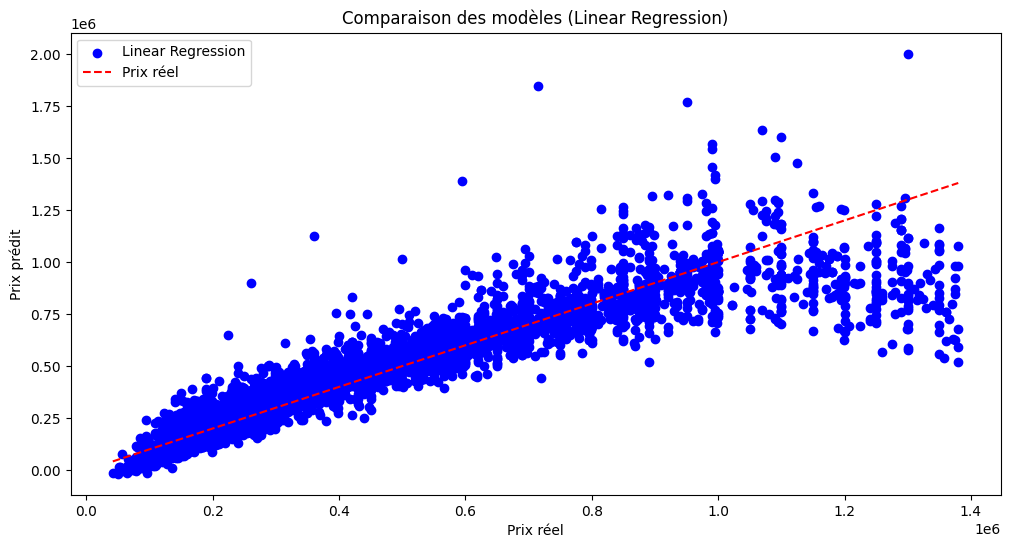

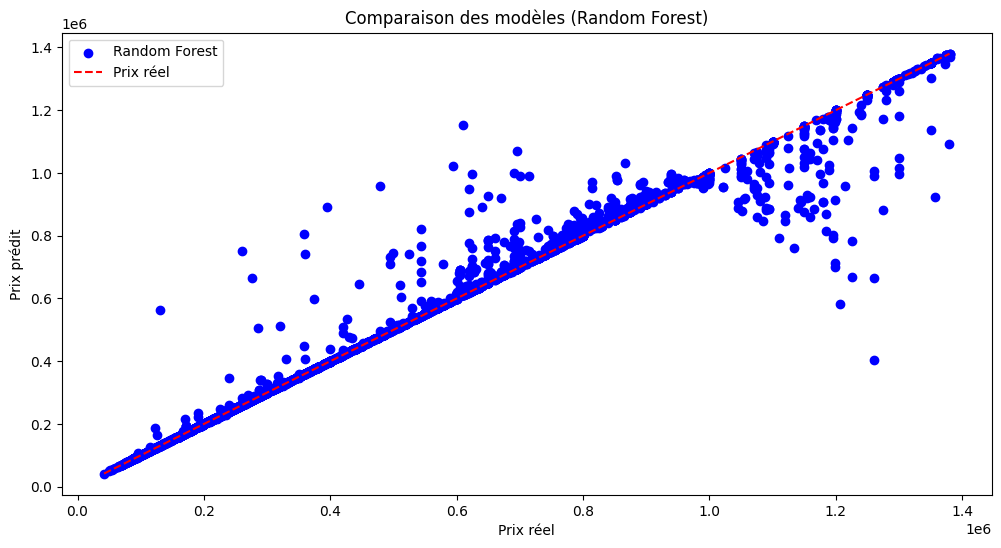

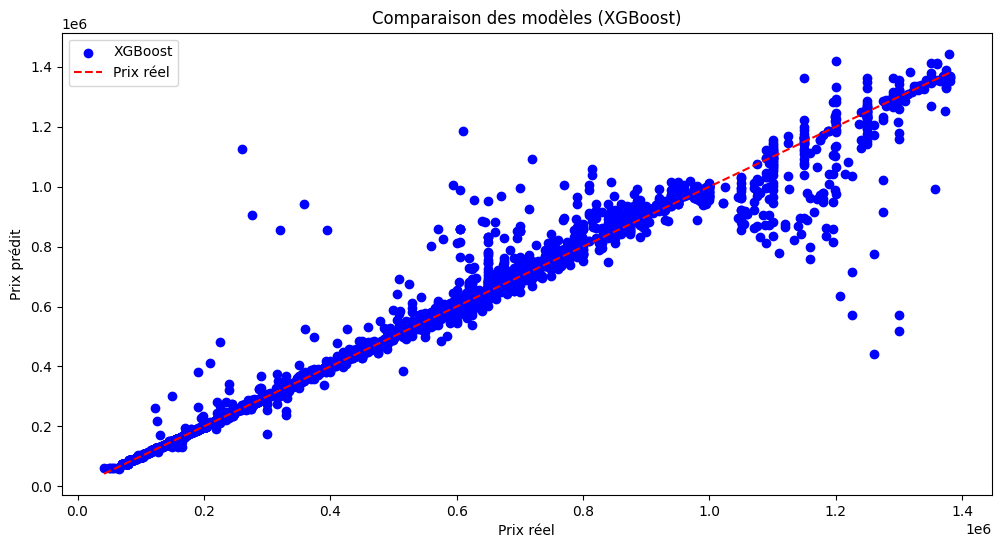

In [20]:
# Comparaison des modèles avec les meilleurs hyperparamètres à l'aide de graphiques
def plot_best_models_comparison(X_test, y_test, best_models):
    for model_name, model in best_models.items():
        y_pred = model.predict(X_test)
        plt.figure(figsize=(12, 6))
        plt.scatter(y_test, y_pred, color='blue')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
        plt.xlabel('Prix réel')
        plt.ylabel('Prix prédit')
        plt.title(f'Comparaison des modèles ({model_name})')
        plt.legend([f'{model_name}', 'Prix réel'])
        plt.show()

plot_best_models_comparison(X_test, y_test, best_models)

### Remarques

Le gridsearch nous permet de comparer nos différents modèles sélectionnés et de trouver le meilleur modèle possible.

On constate que le modèle de régression linéaire est peu performant par rapport aux deux autres modèles cepandant il reste un bon modèle pour une première approche.
En effet, il est mal ajusté pour les données actuelles et ne prend pas en compte les interactions entre les variables.

Les algorithmes de random forest et de XGBoost sont plus performants et plus adaptés pour ce type de données. Ils permettent de capturer les interactions entre les variables et de mieux prédire les prix des biens immobiliers. En effet, ils ont tout deux des scores R² supérieurs à 0.99, ce qui signifie qu'ils expliquent plus de 99% de la variance des prix immobiliers.

La différence notoire se fait principalement sur les graphiques, en effet le modèle de Random Forest a tendance à sur-apprendre les données, ce qui se traduit par une meilleure performance sur les données d'entraînement mais une moins bonne performance sur les données de test.  
Le modèle de XGBoost, quant à lui, est plus stable et généralise mieux les données, ce qui se traduit par une performance plus homogène sur les données d'entraînement et de test.